In [50]:
cd("/tmp/julia/iskra")
import Pkg; Pkg.activate(".")
import Random; Random.seed!(0)
pwd()

 Activating environment at `/private/tmp/julia/iskra/Project.toml`


"/private/tmp/julia/iskra"

In [51]:
include("problem/units_and_constants.jl")
include("problem/configuration.jl")
config = Config();

In [52]:
nx = 20         # number of nodes in x direction
ny = 20         # number of nodes in y direction
ts = 200        # number of time steps
Δh = 5cm        # cell size
Δt = 1ns        # time step
Lx = nx*Δh      # domain length in x direction
Ly = ny*Δh      # domain length in y direction
nothing

In [53]:
xs, ys = 0m:Δh:Lx, 0m:Δh:Ly
sx, sv = [0 Lx; 0 Ly], [0 0; 0 0]
O  = create_fluid_species("O",       1.0,  0qe, 8mp, nx+1, ny+1);
e  = create_kinetic_species("e-", 20_000, -1qe, 1me, 1);
iO = create_kinetic_species("O+", 20_000, +1qe, 8mp, 1);

In [54]:
using Chemistry
import RegularGrid, FiniteDifferenceMethod, ParticleInCell
config.grid    = RegularGrid.create_uniform_grid(xs, ys)
config.cells   = RegularGrid.create_staggered_grid(config.grid)
config.solver  = FiniteDifferenceMethod.create_poisson_solver(config.grid, ε0)
config.pusher  = ParticleInCell.create_boris_pusher()
config.species = [e, O, iO]

σ = CrossSection(3e6:1e6:6e6, [0.01, 0.1, 2.0, 0.01])
collisions = mcc(@reactions begin
    σ, e + O --> O + e
end)
config.interactions = [collisions];

σ: , e- + O-->e- + O	elastic (isotropic): (3.0e6, 6.0e6)
e- MCC Energy range: (0.0, 6.0e6)
e- MCC Velocity range: (0.0, 1.4527848373769622e9)
e- MCC maximal velocity: 1.326205044388061e9


In [55]:
nx, ny = size(config.grid)
mx, my = size(config.cells)
xx, yy = config.grid.coords
δ = ones(nx, ny)
bcs = zeros(Int8, nx, ny)
bcs[ nx,  1] = 1
bcs[ nx, ny] = 2
create_electrode(bcs .== 1, config; σ=1e3ε0);
create_electrode(bcs .== 2, config; fixed=true);

In [56]:
import ParticleInCell
using Diagnostics
using XDMF
using ProgressMeter; ijulia_behavior(:clear)

p = Progress(ts)
function ParticleInCell.after_loop(i, t, dt)
  next!(p; showvalues = [(:iteration, i), (:ne, e.np)])
  
  cd("/tmp")
  new_iteration("04_mcc", i, t, dt) do it
    save_record(it, "phi")
    save_record(it, "nuMCC-e--1")
    save_record(it, "nO")
    save_record(it, "ne-")
    save_record(it, "nO+")
    save_record(it, "E")
    save_records(it, "e-/")
    save_records(it, "O+/")
  end
end

function ParticleInCell.exit_loop()
  println("Exporting to XDMF...")
  cd("/tmp/04_mcc")
  electrons = new_document()
  fields = new_document()
  ions = new_document()
  xdmf(1:ts) do it
    write_species(it, electrons, "e-")
    write_species(it, ions, "O+")
    write_fields(it, fields)
  end
  save_document(electrons, "electrons")
  save_document(fields, "fields")
  save_document(ions, "ions")
end

In [ ]:
ParticleInCell.init(ParticleInCell.MaxwellianSource{2,3}(5e3/Δt, [1.0Lx 1.0Ly], [.5e6 .5e6 .0]), e, Δt)
ParticleInCell.init(ParticleInCell.DensitySource(5e3δ, config.grid), O, Δt)
@time ParticleInCell.solve(config, Δt, ts)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
  iteration:  200
  ne:         4616


Exporting to XDMF...
Complete!
 27.066514 seconds (175.25 M allocations: 26.524 GiB, 17.70% gc time)


### Analysis

In [48]:
using PyPlot
using PyCall
ov = pyimport("openpmd_viewer")
ts = ov.OpenPMDTimeSeries("/tmp/04_mcc/hdf5");

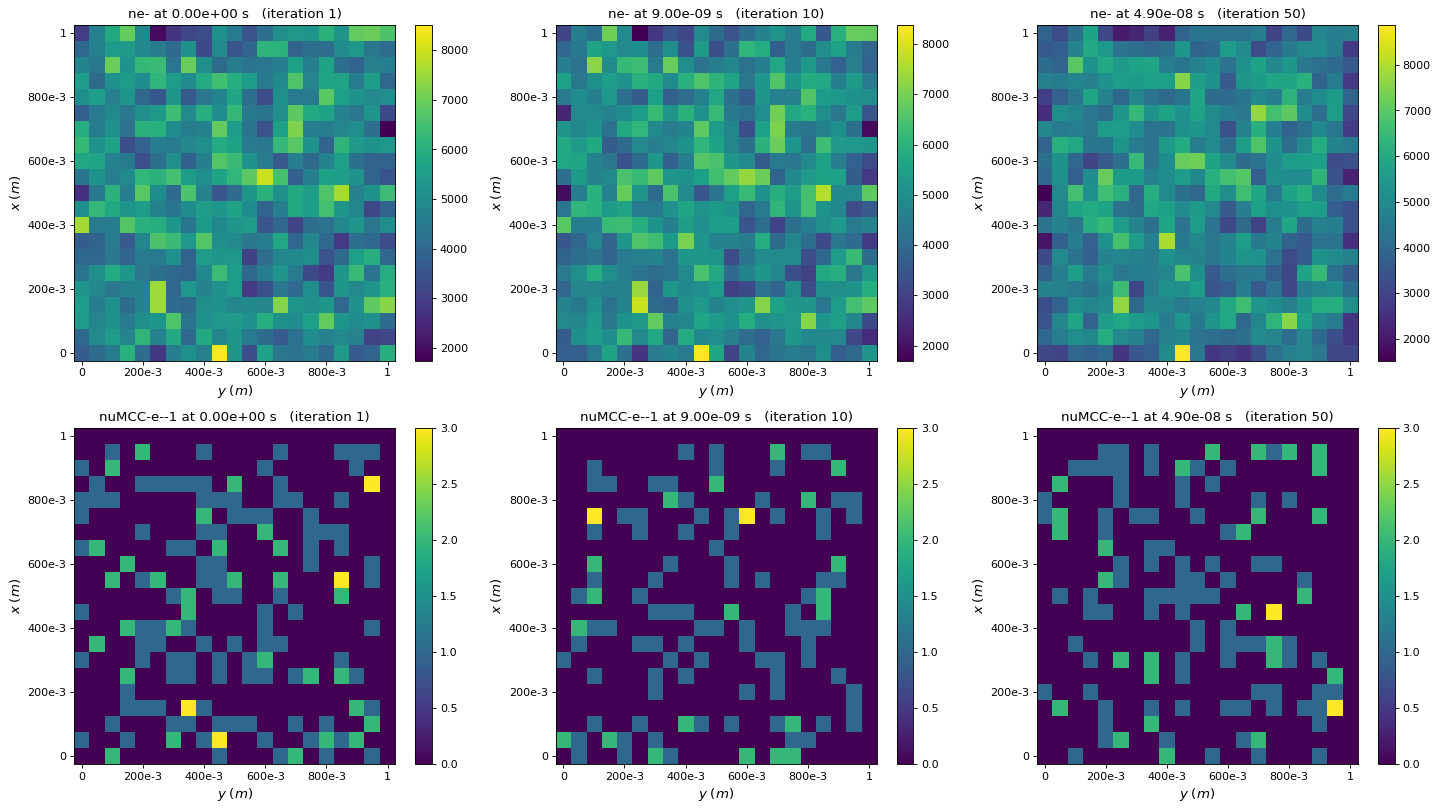

In [49]:
fig = plt.figure(figsize=(22, 12), dpi=80, facecolor="w", edgecolor="k")

plt.subplot(2, 3, 1); ts.get_field("ne-", iteration=1,  plot=true);
plt.subplot(2, 3, 2); ts.get_field("ne-", iteration=10, plot=true);
plt.subplot(2, 3, 3); ts.get_field("ne-", iteration=50, plot=true);

plt.subplot(2, 3, 4); ts.get_field("nuMCC-e--1", iteration=1,  plot=true);
plt.subplot(2, 3, 5); ts.get_field("nuMCC-e--1", iteration=10, plot=true);
plt.subplot(2, 3, 6); ts.get_field("nuMCC-e--1", iteration=50, plot=true);